In [1]:
import pandas as pd 
import math
import numpy as np
from sklearn import preprocessing, cross_validation,    svm
from sklearn.linear_model import LinearRegression
from  datetime import datetime
import matplotlib.pylab  as plt 
from matplotlib import style
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 6  
import time
style.use('ggplot')
from statsmodels.tsa.stattools import adfuller


In [2]:
data = pd.read_csv('cars.csv')
data.head
data['date'] = data['Start Time'].convert_objects(convert_dates='coerce')  
data = data.sort_index(by='date')  
#data = data.dropna(inplace =True)
#data = data.set_index('date')
data['just_date'] = data['date'].dt.date

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [3]:
data[:5]
#data.dtypes

,Start Time,End Time,Plaza,Direction,E-ZPass Total Vehicle Count,Cash Total Vehicle Count,date,just_date
0,01/01/2013 12:00:00 AM,01/01/2013 01:00:00 AM,6,N,196,85,2013-01-01 00:00:00,2013-01-01
1,01/01/2013 12:00:00 AM,01/01/2013 01:00:00 AM,6,S,147,86,2013-01-01 00:00:00,2013-01-01
2,01/01/2013 01:00:00 AM,01/01/2013 02:00:00 AM,6,N,320,141,2013-01-01 01:00:00,2013-01-01
3,01/01/2013 01:00:00 AM,01/01/2013 02:00:00 AM,6,S,251,149,2013-01-01 01:00:00,2013-01-01
4,01/01/2013 02:00:00 AM,01/01/2013 03:00:00 AM,6,N,238,121,2013-01-01 02:00:00,2013-01-01


In [4]:
data['totalCars'] = data['E-ZPass Total Vehicle Count'] + data['Cash Total Vehicle Count']

In [5]:
data = data.drop('Start Time',1)
data = data.drop('End Time',1)
data = data.drop('Plaza',1)

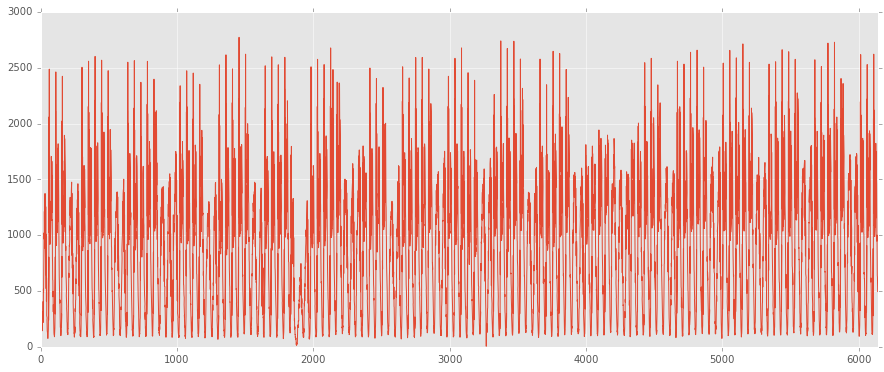

In [6]:
data['totalCars'].plot()

In [7]:
dataNorth = data[data.Direction != 'S']
dataNorth['just_date']  = data['just_date']

dataSouth = data[data.Direction != 'N']
dataSouth['just_date']  = data['just_date']
 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


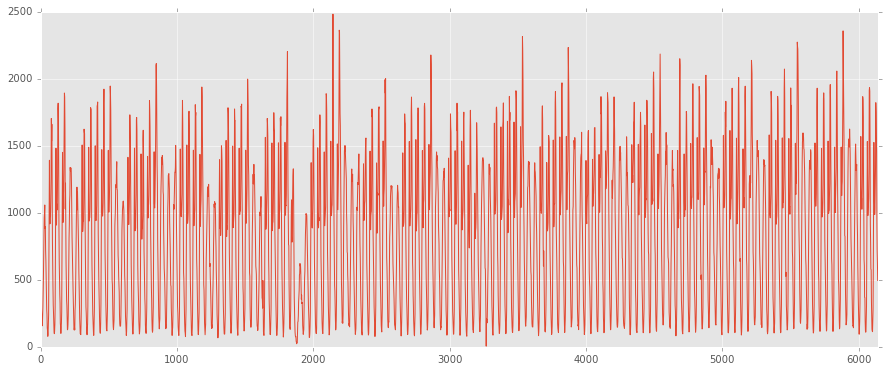

In [8]:
dataNorth['totalCars'].plot()

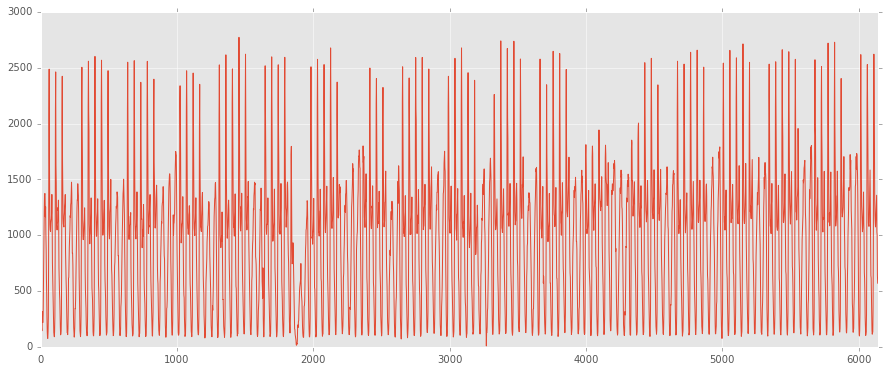

In [9]:
dataSouth['totalCars'].plot()

In [10]:
#data['dailyCarsSouth'] = dataSouth.groupby('just_date').sum()['totalCars']
cols = ['North', 'South']
dailyRecord = pd.DataFrame(columns = cols)


dailyRecord['South'] =  dataSouth.groupby('just_date',as_index = True).sum()['totalCars']
dailyRecord['North'] =  dataNorth.groupby('just_date',as_index = True).sum()['totalCars'] 

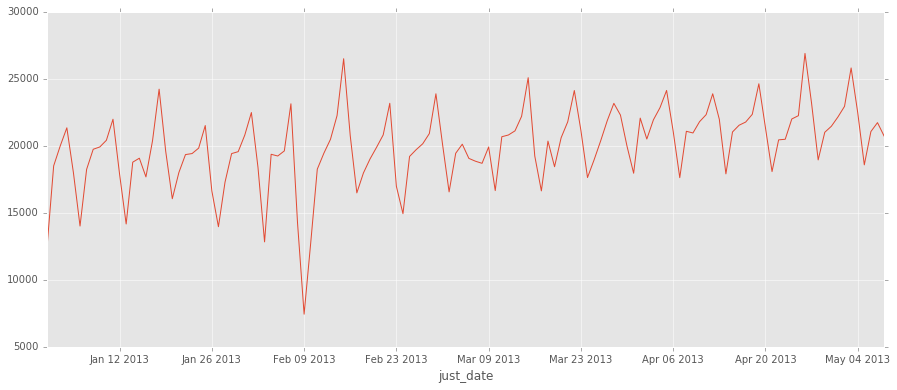

In [11]:
#dailyRecord['North']
dailyRecord['North'].plot()

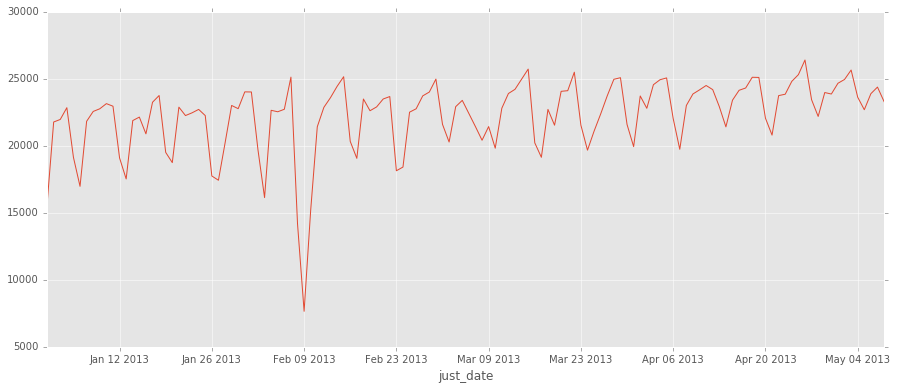

In [12]:
dailyRecord['South'].plot()

In [13]:
dailyRecord.columns

Index([u'North', u'South'], dtype='object')

In [14]:
 dailyRecord.index

Index([2013-01-01, 2013-01-02, 2013-01-03, 2013-01-04, 2013-01-05, 2013-01-06,
       2013-01-07, 2013-01-08, 2013-01-09, 2013-01-10,
       ...
       2013-04-29, 2013-04-30, 2013-05-01, 2013-05-02, 2013-05-03, 2013-05-04,
       2013-05-05, 2013-05-06, 2013-05-07, 2013-05-08],
      dtype='object', name=u'just_date', length=128)

In [15]:
dailyRecord[5:6 ]

,North,South
just_date,,
2013-01-06,14017,16982


In [16]:
dailyRecord.index.name= 'date'

In [17]:
dailyRecord.index = pd.to_datetime(dailyRecord.index)
dailyRecord['date'] = dailyRecord.index

In [18]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    # dftest = adfuller(timeseries.unstack(), autolag=’AIC’)
    dftest = adfuller(timeseries.unstack(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [19]:
dailyRecord[:5]
dates_input = dailyRecord.index.values.astype('datetime64[D]')
dailyRecord['dateset'] = dates_input
dailyRecord.set_index('dateset') 
dailyRecord.drop('dateset', axis=1, inplace=True)
dailyRecord[:5]


,North,South,date
date,,,
2013-01-01,12486,15637,2013-01-01
2013-01-02,18512,21786,2013-01-02
2013-01-03,20005,21976,2013-01-03
2013-01-04,21352,22856,2013-01-04
2013-01-05,17991,19150,2013-01-05


In [23]:
#test_stationarity(dailyRecord)
dailyRecord.index
dailyRecord.drop('date', axis=1, inplace=True)
#dailyRecord.drop('dateset', axis=1, inplace=True)
dailyRecord[:5]
#dailyRecord.drop('North',axis = 1 ,inplace = True)

,South
date,
2013-01-01,15637
2013-01-02,21786
2013-01-03,21976
2013-01-04,22856
2013-01-05,19150


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


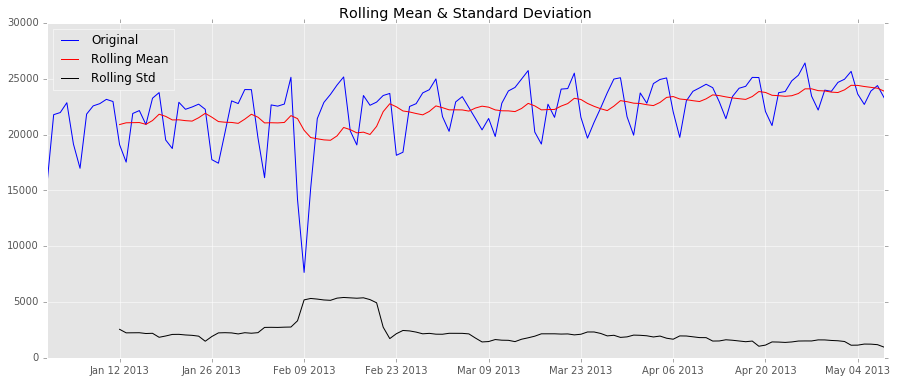

Results of Dickey-Fuller Test:
Test Statistic                  -0.638907
p-value                          0.861946
#Lags Used                      13.000000
Number of Observations Used    114.000000
Critical Value (5%)             -2.887246
Critical Value (1%)             -3.489058
Critical Value (10%)            -2.580481
dtype: float64


In [24]:
test_stationarity(dailyRecord)


In [25]:
from statsmodels.tsa.stattools import acf, pacf

In [37]:
lag_acf = acf(dailyRecord, nlags= 25)
lag_pacf = pacf(dailyRecord, nlags= 25, method='ols')


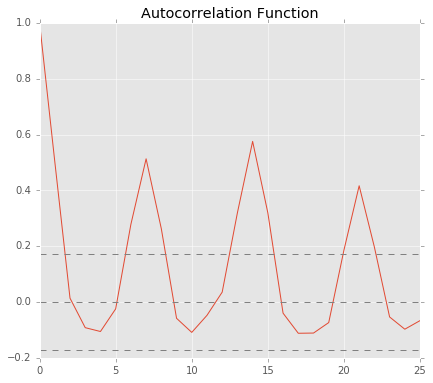

In [38]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dailyRecord)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dailyRecord)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


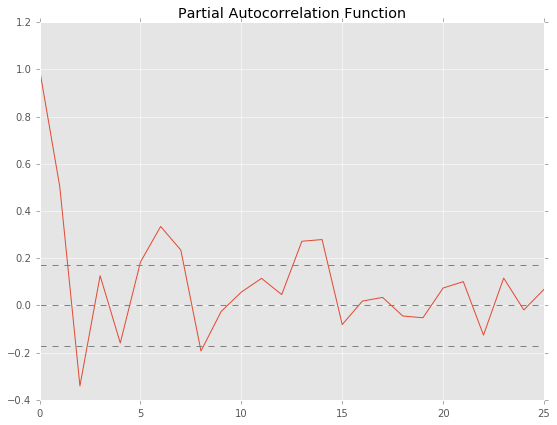

In [39]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dailyRecord)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dailyRecord)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [40]:
from statsmodels.tsa.arima_model import ARIMA

In [51]:
dailyRecord['South'] = dailyRecord['South'].astype(float)


1018.3300665295596

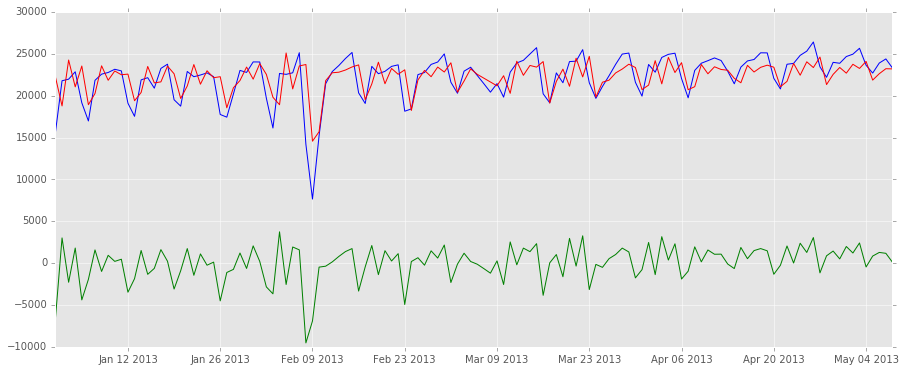

In [90]:
model = ARIMA( dailyRecord, order=( 2, 0,2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(dailyRecord, color='blue' )
plt.plot(results_ARIMA.fittedvalues, color='red')

err = dailyRecord['South'] -  results_ARIMA.fittedvalues
plt.plot(err , color='green' )
errPcent = (dailyRecord['South'] -  results_ARIMA.fittedvalues)*100/dailyRecord['South']
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-dailyRecord)**2))
absError = np.absolute(errPcent)
absError.sum()